# NN Project

Step by step : 


1.   Convert the audio files into spectrogramms
2.   Define the Dataset and the different dataloaders
3.   Define the classifier with the different layers used 
4.   Define the evaluation and the training function
5.   Apply the training procedure and observe the plot
6.   Do some adjustments and voilà !




# Step 0 : imports and connection to GG Drive 


In [ ]:
import torch
import fnmatch
import matplotlib.pyplot as plt
import soundfile as sf
import os
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from skimage import io
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import librosa
import torch.nn as nn
import torch.nn.functional as F
import copy


### Optionnal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1 : audio files into spectrogramms 

In [ ]:
# To convert a flac file into a spectrogramm

def flac_to_spectro(file_path):
  waveform, sample_rate = torchaudio.load(file_path, normalize=True)
  transform = T.MelSpectrogram(sample_rate)
  mel_specgram = transform(waveform)
  return mel_specgram  

In [ ]:
# To plot the Melspectrogramm 

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


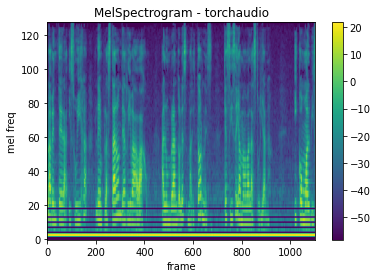

In [ ]:
# Example
spectro = flac_to_spectro("/content/drive/MyDrive/neural networks project/test_set_es/data_sample/es_f_50298ab71aaba8508ebeef49d853df11.fragment17.flac")
plot_spectrogram(spectro[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

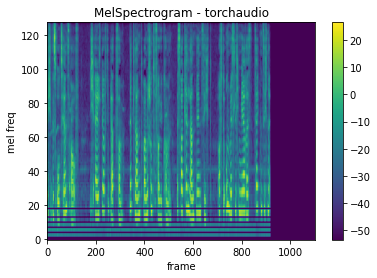

In [ ]:
# Example
spectro = flac_to_spectro("/content/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment10.speed8.flac")
plot_spectrogram(spectro[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

# Step 2 : Define the Dataset and the different dataloaders

# TODO 
the labels are in the name of the flac file, so extract it 
However I need other data than the ones from the test set to get acces to the labels embedded in the file path 


In [ ]:
class SpeechDataset(Dataset):

    def __init__(self, flac_dir):
        self.audio_path_list = sorted(self.find_files(flac_dir))
        # Conversion into spectrogramms 
        self.specto_data = []
        for f_path in self.audio_path_list:
          self.specto_data.append(flac_to_spectro(f_path))
        # TODO Convert it into an actual image ? I don't think so 
        self.labels = self._get_labels()

    def __len__(self):
        # return len(self.audio_path_list)
        return len(self.specto_data)

    def __getitem__(self, index):
      # Retrieve the corresponding audio
        audio_path = self.audio_path_list[index]
        # transform it into a spectrogramm
        # Retrieve the corresponding spectrogram 
        spectro = self.specto_data[index]
        label = self._get_label(audio_path)
        features = {'spectrogram': spectro, 'labels': label}
        return features

        #with open(audio_path, "rb") as f:
            #data, samplerate = sf.read(f)
        #return data, samplerate
        #return self.specto_data[index]

    def find_files(self, directory, pattern="*.flac"):
        """
        Recursive search method to find files. Credit to Paul Magron for OG method
        """
        audio_path_list = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                audio_path_list.append(os.path.join(root, filename))
        return audio_path_list
    
    def _get_labels(self):
      """Extract the labels from the given audio files."""
      labels = []
      for filepath in self.audio_path_list:
        label = filepath.split(".")[2]
        labels.append(label)
      return labels

    def _get_label(self, audio_path):
      """Extract the label from the single given audio file."""
      label = audio_path.split(".")[2]
      return label


/content/dir/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment10.speed8.flac
['/content/dir/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment10.speed8.flac']
torch.Size([128, 1103])


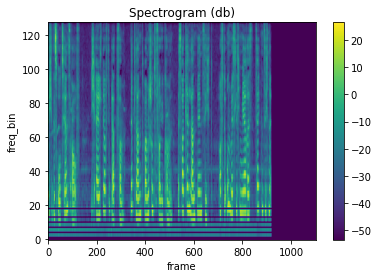

speed8


In [ ]:
#data_dir = "/content/drive/MyDrive/neural networks project/test_set_es/data_sample/"
data_dir = "/content/dir/"
# Prepare the Dataset
dataset = SpeechDataset(flac_dir=data_dir)

# Small example 
features_example = dataset.specto_data[0][0]
#print(features_example)
print(features_example.shape)
plot_spectrogram(features_example)

features_dict = dataset.__getitem__(0)
print(features_dict['labels'])


In [ ]:
# Prepare the Dataloader
train_data = Subset(dataset, torch.arange(240)) # 80% 
test_data = Subset(dataset, torch.arange(60))  # 20%
print('Number of files in the train dataset', len(train_data))
print('Number of files in the test dataset', len(test_data))


#batch_size = 16  # TODO determine a decent batch size
#speech_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



# Create the dataloaders
batch_size = 16
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
print('Number of files in the train DataLoader', len(train_dataloader))
print('Number of files in the test DataLoader', len(test_dataloader))

Number of files in the train dataset 240
Number of files in the test dataset 60
Number of files in the train DataLoader 15
Number of files in the test DataLoader 4


# Step 3 : Define the classifier

In [ ]:
# Get a batch of images and corresponding labels from the train dataloader
#train_dataloader[0]# TODO resolve this problem 

for features in train_data:
    token_ids = features['spectrogram']
    labels = features['labels']
    print(token_ids)
    print(labels)

# Get a batch of images and corresponding labels from the train dataloader
batch_example = next(iter(train_dataloader))
image_batch_example = batch_example[0]
labels_batch_example = batch_example[1]

# Print the size of the batch of images and labels
print(image_batch_example.shape)
print(labels_batch_example.shape)

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [7.6180e+00, 3.4561e-02, 1.8264e-02,  ..., 8.6166e-09,
          4.4177e-09, 1.5986e-08],
         ...,
         [6.7770e-02, 5.7044e-04, 1.8590e-03,  ..., 7.8187e-08,
          1.1636e-07, 9.6967e-08],
         [1.5527e-01, 7.3847e-04, 1.4846e-03,  ..., 1.1540e-07,
          2.8267e-07, 6.3318e-08],
         [2.0075e-01, 4.9539e-05, 1.7191e-04,  ..., 1.6377e-07,
          2.8192e-07, 4.9610e-08]]])
speed8


IndexError: ignored

# TODO 

Do a study of the variation of the performances in function of the architecture (nb of layers, nb of convolutions, etc.) 

Also study the different loss functions and optimizers. 

In [ ]:
# TODO this is just a filler I don't think this going to lead to good results :(
# See slide 129 of the lecture 
# The method I used is great for classification so we should adapt it to our problem
# [INPUT - CONV - RELU - POOL - FC]
# INPUT : 128, 1103, 3
# CONV : 128, 1103, 12 ??
# RELU : just being ReLu
# POOL : using F.max_pool2d ? 
# FC : Linear with 1, 1, 10 where 10 the number of classes ?? --> do we have classes ? 


class SpectroClassif(nn.Module):
    def __init__(self, act_fn):  # TODO instead of input_size, etc. put the obj and do obj.shape
        super(SpectroClassif, self).__init__()
        # TODO I guess we need use nn.Conv2d to process the images 
        #self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), act_fn)
        #self.hidden_layer = nn.Sequential(nn.Linear(hidden_size, hidden_size), act_fn)
        #self.output_layer = nn.Linear(hidden_size, output_size)
        self.input_layer = nn.Linear(128, 1103)
        self.conv1 = nn.Sequential(nn.Conv2d(16, 3, 3), act_fn)
        self.pool1 = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 3, 3), act_fn)
        self.pool2 = nn.MaxPool2d(3,3)
        self.dropout = nn.Dropout(0.3)
        self.softmax = nn.Softmax2d()
        
    def forward(self, x):
        # Input layer
        x = self.input_layer(x)
        # 1st Conv
        x = self.conv1(x)
        # 1st pooling layer 
        x = self.pool1(x)
        # 2nd conv
        x = self.conv2(x)
        # 2nd pooling layer 
        x = self.pool2(x)
        # Dropout 
        x = self.dropout(x)
        # softmax 
        out = self.softmax(x)
        return out

In [ ]:
## Hyperparameters  TODO change

nb_channels_in = 3
nb_channels_out = 3
# kernel_size = the first input size ?? 
input_size = 128
size_lay2 = 3


In [ ]:
#### Just printing the model ####

act_fn= torch.nn.ReLU()
model = SpectroClassif(act_fn)
print(model)

SpectroClassif(
  (input_layer): Linear(in_features=128, out_features=1103, bias=True)
  (conv1): Sequential(
    (0): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (softmax): Softmax2d()
)


# Step 4 : Define the eval and training functions 

We need to define a training objective 

I don't know if there are labels in this dataset


In [ ]:
def train_spectroClassif(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):
    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)  # TODO first test with Adam 

    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader 
        for batch_index, (spectro, labels) in enumerate(train_dataloader):  # TODO it won't return labels right ? 
            # Prepare the inputs and labels
            #print(images.shape)
            spectro = spectro.reshape(spectro.shape[0], -1)
            #print(images.shape)
            
            # Forward pass
            feature_predicted = model_tr(spectro)
            #print(images_predicted.shape)
            feature_predicted = feature_predicted.reshape(feature_predicted.shape[0], -1)
            #print(images_predicted.shape)
            
            # Backpropagation
            loss = loss_fn(feature_predicted, spectro)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Add the batch loss to the current epoch loss
            loss_current_epoch += loss.item()

        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model_tr, loss_all_epochs

In [ ]:
num_epochs = 300
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()

model, loss_all_epochs = train_spectroClassif(model, train_dataloader, num_epochs, loss_fn, learning_rate)
#torch.save(model.state_dict(), 'model_mlp_autoencoder.pt')

plt.figure()
plt.plot(torch.arange(num_epochs)+1, loss_all_epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

TypeError: ignored

# Step 5 : Train the model

# Step 6 : Adjusting